In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from numpy import array
import math
from sklearn.metrics import r2_score
from keras.models import load_model
#from keras.engine.input_layer import InputLayer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras import losses
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [ ]:
from numpy.core import numerictypes
import random
import matplotlib.pyplot as plt


import pandas as pd

# Load your dataset from a CSV file
Ap = pd.read_csv('final_dataset_with_ev1.csv')


# Split the dataset into train and test sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(Ap))
train = Ap[:train_size]
test = Ap[train_size:]

# Optionally, you can reset the index of the DataFrames if needed
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


In [ ]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
scalers={}
for i in train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test
for i in train.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

print(test,train)

      Active Power
0        -0.540875
1        -0.547462
2        -0.603197
3        -0.637148
4        -0.343200
...            ...
7003     -0.841639
7004     -0.834403
7005     -0.824703
7006     -0.838245
7007     -0.848711

[7008 rows x 1 columns]        Active Power
0         -0.506325
1         -0.534790
2         -0.587234
3         -0.586834
4         -0.494941
...             ...
28027     -0.829332
28028     -0.866948
28029     -0.858467
28030     -0.814420
28031     -0.874287

[28032 rows x 1 columns]


<ipython-input-50-1741e1793d5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-50-1741e1793d5d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [ ]:
# Assuming n_features is 1 for a single feature "Active Power"
n_features = 1
n_past = 96# Number of past time steps to consider
n_future = 1  # Number of future time steps to predict

X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(27936, 96, 1) (27936, 1, 1)
(6912, 96, 1) (6912, 1, 1)


In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
model_e1d1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 1)]              0         []                            
                                                                                                  
 lstm_6 (LSTM)               [(None, 100),                40800     ['input_4[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 1, 100)               0         ['lstm_6[0][0]']              
 tor)                                                                                       

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=64,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
437/437 [==============================] - 8s 11ms/step - loss: 0.0079 - val_loss: 0.0045 - lr: 0.0010
Epoch 2/25
437/437 [==============================] - 5s 11ms/step - loss: 0.0046 - val_loss: 0.0043 - lr: 9.5000e-04
Epoch 3/25
437/437 [==============================] - 4s 9ms/step - loss: 0.0045 - val_loss: 0.0048 - lr: 9.0250e-04
Epoch 4/25
437/437 [==============================] - 4s 9ms/step - loss: 0.0045 - val_loss: 0.0041 - lr: 8.5737e-04
Epoch 5/25
437/437 [==============================] - 5s 11ms/step - loss: 0.0044 - val_loss: 0.0043 - lr: 8.1451e-04
Epoch 6/25
437/437 [==============================] - 4s 9ms/step - loss: 0.0044 - val_loss: 0.0044 - lr: 7.7378e-04
Epoch 7/25
437/437 [==============================] - 4s 9ms/step - loss: 0.0044 - val_loss: 0.0042 - lr: 7.3509e-04
Epoch 8/25
437/437 [==============================] - 5s 11ms/step - loss: 0.0043 - val_loss: 0.0042 - lr: 6.9834e-04
Epoch 9/25
437/437 [==============================] - 4s 10ms/st

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)

216/216 [==============================] - 1s 4ms/step


In [ ]:
for index,i in enumerate(train.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
# Access elements using a single index
print(pred_e1d1[index-3])



[[4.54501]]


In [ ]:
print(pred_e1d1[:,:,0])

[[4.8903084]
 [4.7283506]
 [4.647009 ]
 ...
 [4.54501  ]
 [4.606802 ]
 [4.589881 ]]


In [ ]:
pre_Ap=pred_e1d1[:,:,0]
act_Ap=y_test[:,:,0]
pre_S1 = pred_e1d1
pre_S1 = pred_e1d1
act_S1 = y_test

pre_S2 = pred_e1d1

act_S2 = y_test
pre_S3 = pred_e1d1

act_S3 = y_test

print("predicted",pre_Ap)
print("Actual",act_Ap)


predicted [[4.8903084]
 [4.7283506]
 [4.647009 ]
 ...
 [4.54501  ]
 [4.606802 ]
 [4.589881 ]]
Actual [[4.1702483 ]
 [4.40370197]
 [4.2817773 ]
 ...
 [4.52701339]
 [4.437592  ]
 [4.368478  ]]


In [ ]:
#res = pd.DataFrame(data={'Train Predictions':train_pre, 'Actuals':y_test})

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate metrics on training data
train_preds = model_e1d1.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train[:, 0, index], train_preds[:, 0, index]))
train_mae = mean_absolute_error(y_train[:, 0, index], train_preds[:, 0, index])

# Calculate metrics on testing data
test_rmse = math.sqrt(mean_squared_error(y_test[:, 0, index], pred_e1d1[:, 0, index]))
test_mae = mean_absolute_error(y_test[:, 0, index], pred_e1d1[:, 0, index])

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}")

873/873 [==============================] - 3s 4ms/step
Train RMSE: 6.699616867815612, Train MAE: 6.506260701817517
Test RMSE: 0.5001277038528259, Test MAE: 0.33665002304008673


In [ ]:
#Code for writing actual and predicted values to csv
import pandas as pd

# Assuming pre_Ap and act_Ap are NumPy arrays
pre_Ap_flat = pre_Ap.flatten()
act_Ap_flat = act_Ap.flatten()

# Create a DataFrame with both predicted and actual values
df = pd.DataFrame({'Predicted': pre_Ap_flat, 'Actual': act_Ap_flat})

# Save the DataFrame to a CSV file with headers
df.to_csv('Act_vs_pred.csv', index=False)

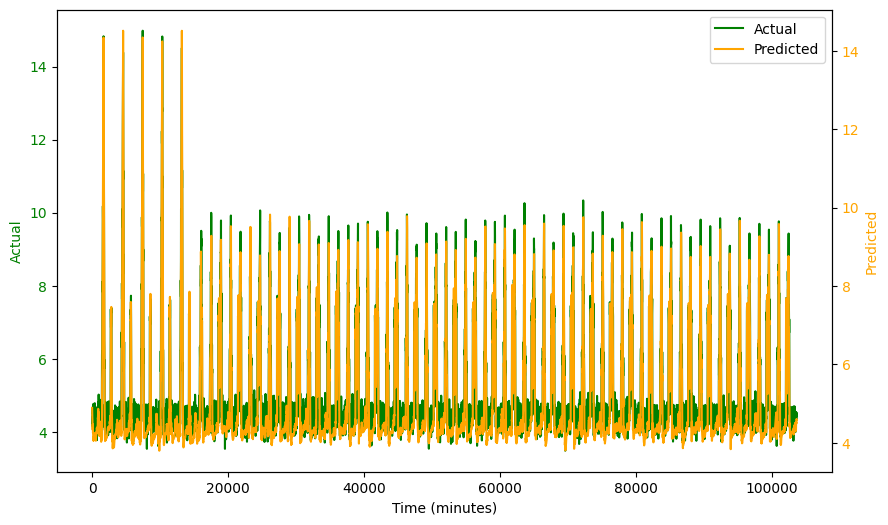

In [ ]:
# Comparision graph wrt time (15 mins intervel)
import numpy as np
import matplotlib.pyplot as plt

# Assuming pre_Ap and act_Ap are NumPy arrays representing time series data with 15-minute intervals
time_intervals = np.arange(0, len(pre_Ap)) * 15  # Assuming the data starts at 0 and increments by 15 minutes

# Create a figure and two axes
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the actual values in green on the primary y-axis
ax1.plot(time_intervals, act_Ap, label='Actual', color='green')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Actual', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary y-axis for predicted values in orange
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(time_intervals, pre_Ap, label='Predicted', color='orange')
ax2.set_ylabel('Predicted', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels)

# Show the plot
plt.show()


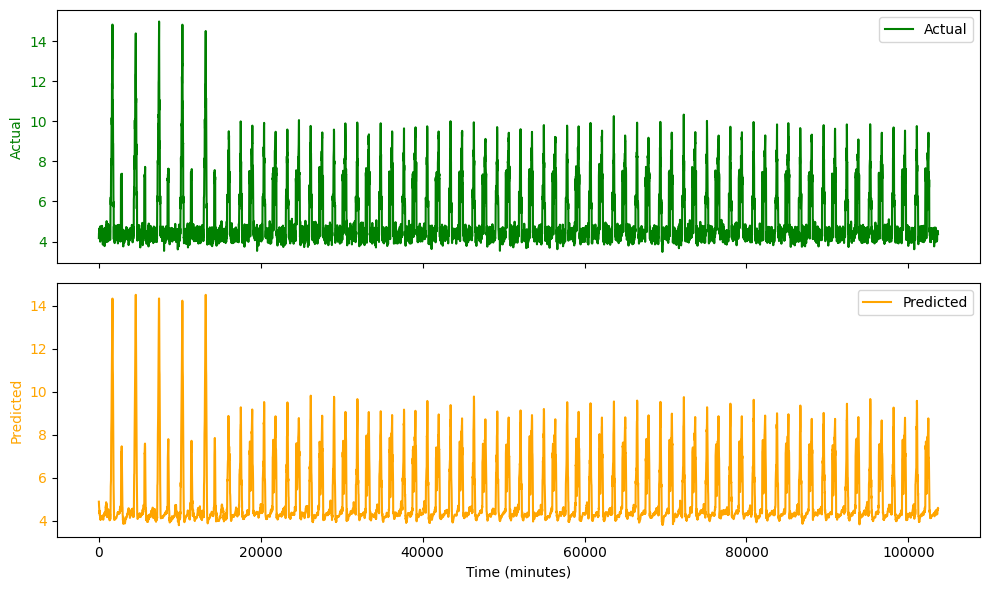

In [ ]:
#Plotting separately wrt time (15 mins intervel)

import numpy as np
import matplotlib.pyplot as plt

# Assuming pre_Ap and act_Ap are NumPy arrays representing time series data with 15-minute intervals
time_intervals = np.arange(0, len(pre_Ap)) * 15  # Assuming the data starts at 0 and increments by 15 minutes

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot the actual values in green on the first subplot
ax1.plot(time_intervals, act_Ap, label='Actual', color='green')
ax1.set_ylabel('Actual', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.legend()

# Plot the predicted values in orange on the second subplot
ax2.plot(time_intervals, pre_Ap, label='Predicted', color='orange')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Predicted', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend()

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()


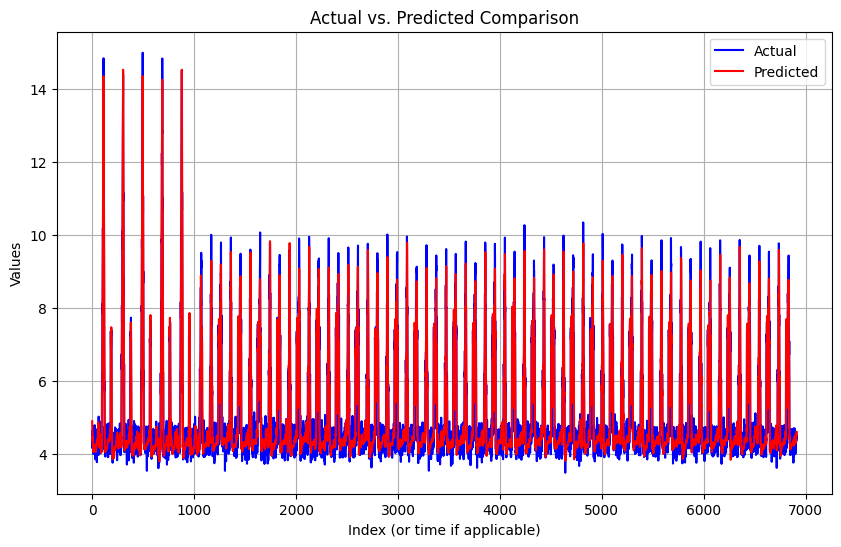

In [ ]:
#Line graph wrt no.of values in excel
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pre_Ap and act_Ap are NumPy arrays
pre_Ap_flat = pre_Ap.flatten()
act_Ap_flat = act_Ap.flatten()

# Create a DataFrame with both predicted and actual values
df = pd.DataFrame({'Predicted': pre_Ap_flat, 'Actual': act_Ap_flat})

# Save the DataFrame to a CSV file with headers (optional)
df.to_csv('Act_vs_pred.csv', index=False)

# Create a comparison plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the actual values in blue
plt.plot(df.index, df['Actual'], label='Actual', color='blue')

# Plot the predicted values in red
plt.plot(df.index, df['Predicted'], label='Predicted', color='red')

plt.title('Actual vs. Predicted Comparison')
plt.xlabel('Index (or time if applicable)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Save or show the plot
plt.savefig('comparison_plot.png')  # Save the plot as an image file (optional)
plt.show()


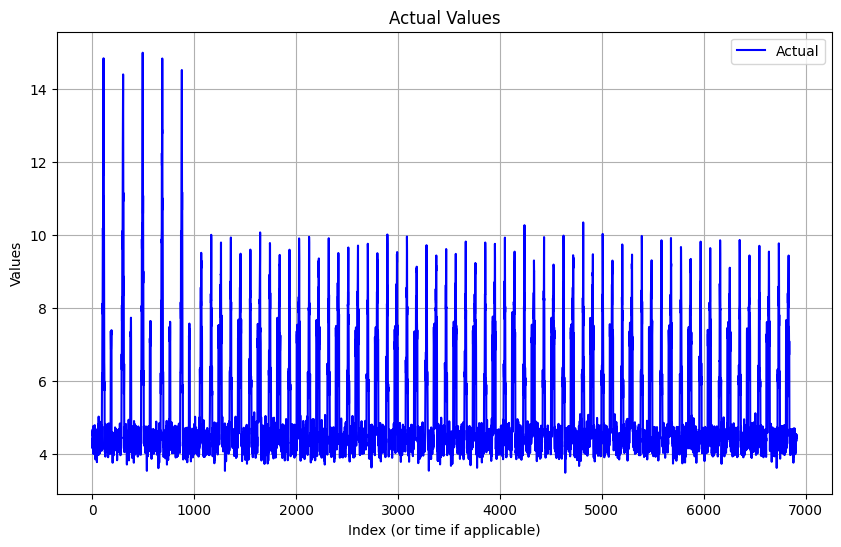

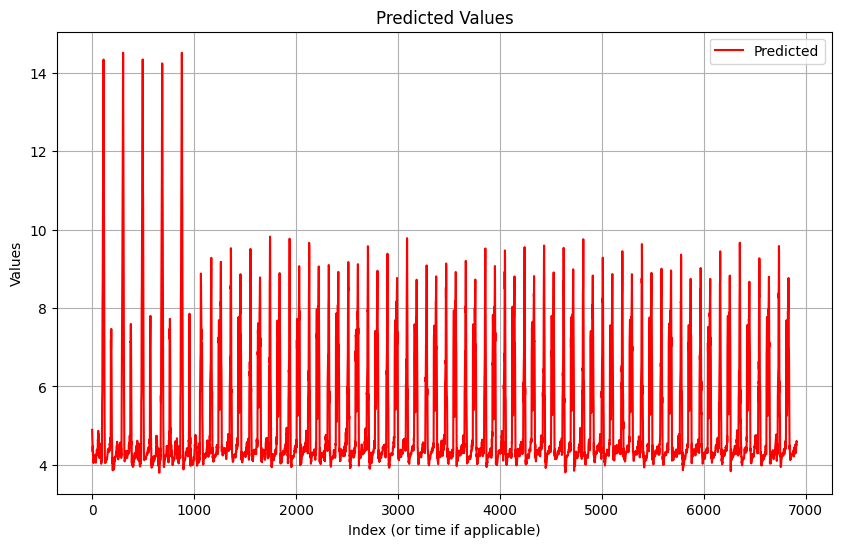

In [ ]:
#Line graphs separately wrt no.of values in excel
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pre_Ap and act_Ap are NumPy arrays
pre_Ap_flat = pre_Ap.flatten()
act_Ap_flat = act_Ap.flatten()

# Create a DataFrame with both predicted and actual values
df = pd.DataFrame({'Predicted': pre_Ap_flat, 'Actual': act_Ap_flat})

# Save the DataFrame to a CSV file with headers (optional)
df.to_csv('Act_vs_pred.csv', index=False)

# Create a separate line graph for actual values
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the actual values in blue
plt.plot(df.index, df['Actual'], label='Actual', color='blue')

plt.title('Actual Values')
plt.xlabel('Index (or time if applicable)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Save or show the plot
plt.show()

# Create a separate line graph for predicted values
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the predicted values in red
plt.plot(df.index, df['Predicted'], label='Predicted', color='red')

plt.title('Predicted Values')
plt.xlabel('Index (or time if applicable)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Save or show the plot
plt.show()
